In [1]:
%matplotlib inline

# PLANE OF SKY (POS) MAGNETIC FIELD STRENGTH III
Author: Jordan Guerra (for Villanova University). May 2024.

This tutorial illustrates the use of the package *polBpy* for constructing maps of plane-of-sky (POS) magnetic field strength ($B_{\rm POS}$) using the different DCF approximations. 

This tutorial uses data from literature listed [here.](https://github.com/jorgueagui/polBpy/blob/9039d4af5d25c49130bf51be7fe0ce363424edcc/refs.md)

**EXAMPLE I**: This example illustrate the use of DCF approximations when canstructing maps of $B_{\rm POS}$. We reproduce here some results from Tram+23, which presents maps of $B_{\rm POS}$ calculated from the dispersion analysis peformed to SOFIA/HAWC+ 89-$\mu$m (Figure 10, top) observations of the 30-Dor region.

In [33]:
from polBpy import dispersion, fitting, utils
from polBpy import DCF
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm
from matplotlib import patches
from scipy.ndimage import gaussian_filter

First, we read in the polarimetric data from a FITS file (polarimetric data will not be used in any calculations here but they will be needed some information such as pixel size)

In [34]:
from astropy.io import fits
import os
cdir = os.path.dirname(os.getcwd())
file = '/users/nsalem/Merged_Full_Polarization_Rotated.fits'
data = fits.open(file)
print(data.info())

Filename: /users/nsalem/Merged_Full_Polarization_Rotated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU    1490   (1900, 950)   float64   
  1  ERROR I       1 ImageHDU        19   (1900, 950)   float64   
  2  STOKES Q      1 ImageHDU        19   (1900, 950)   float64   
  3  ERROR Q       1 ImageHDU        19   (1900, 950)   float64   
  4  STOKES U      1 ImageHDU        19   (1900, 950)   float64   
  5  ERROR U       1 ImageHDU        19   (1900, 950)   float64   
  6  IMAGE MASK    1 ImageHDU        60   (1900, 950)   float64   
  7  PERCENT POL    1 ImageHDU        19   (1900, 950)   float64   
  8  DEBIASED PERCENT POL    1 ImageHDU        19   (1900, 950)   float64   
  9  ERROR PERCENT POL    1 ImageHDU        19   (1900, 950)   float64   
 10  POL ANGLE     1 ImageHDU        19   (1900, 950)   float64   
 11  ROTATED POL ANGLE    1 ImageHDU        19   (1900, 950)   float64   
 12  ERROR POL ANGLE    1 ImageHDU        19   

Let us define some polarimetric variables

In [35]:
StokesI = data['STOKES I'].data[588:655, 994:1065]
StokesI_err = data['ERROR I'].data[588:655, 994:1065]
p_flux = data['DEBIASED POL FLUX'].data[588:655, 994:1065] # 
p_flux_err = data['ERROR POL FLUX'].data[588:655, 994:1065] #

And define pixel and beam size

In [38]:
pixel_size = data[0].header['CDELT2']*3600 #in arcsec
beam_size = 9.37*pixel_size # in arcsec
print('Pixel size = %s [arcsec]'%pixel_size)
print('Beam FWHM = %s [arcsec]'%beam_size)

Pixel size = 4.550000000000001 [arcsec]
Beam FWHM = 42.633500000000005 [arcsec]


In Tram+23, a reference mask is created for pixels that satisfy $I/\sigma_{I}>100$ and $p/\sigma_{p}>3$ (this will be used to draw reference contours such as those in Figure 10)

In [39]:
mask = np.full_like(StokesI,0.0)
m = np.where((StokesI/StokesI_err > 200.) & (p_flux/p_flux_err > 3.0) ) #ring paper is 200 
mask[m] = 1.0

We read some of the variables for the DCF calculations from a different FITS file

In [40]:
import pickle

In [41]:
#cloud depth from region mask
with open('cloud_depth.pkl', 'rb') as file:
    cloud_depth = pickle.load(file)

In [77]:
cloud_depth = cloud_depth * 1.2266e17

In [79]:
type(cloud_depth[0][0])

numpy.float64

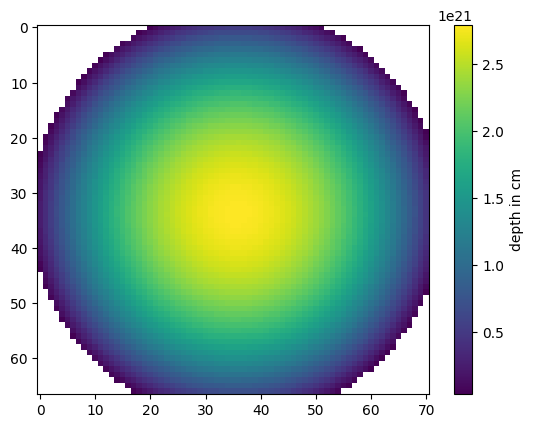

In [81]:
cbar=plt.imshow(cloud_depth)
cb=plt.colorbar(cbar, label='depth in cm')

In [71]:
#col den from marsh paper

#units 10^20 cm^-2


from astropy import wcs
from reproject import (reproject_interp, reproject_exact)

colden = fits.open('/users/nsalem/polBpy tutorials/l000_cdens.fits')[0]
wcden = wcs.WCS(colden)
col_den_map,_ = reproject_interp((colden.data,wcden),data[0].header)
col_den_map = col_den_map[588:655, 994:1065]
col_den_map = col_den_map * 10**20
col_den_map = np.float64(col_den_map)

In [72]:
type(col_den_map[0][1])

numpy.float64

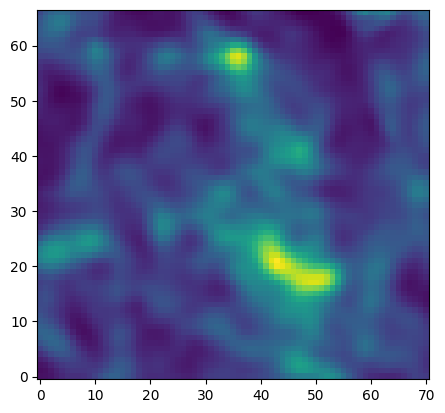

In [73]:
plt.imshow(col_den_map, origin='lower')

In [61]:
type(col_den_map)

numpy.ndarray

In [44]:
#vel disp from moment 2 13CO map
with open('veldisp.pkl', 'rb') as file:
    vel_disp = pickle.load(file)
vel_disp_map = vel_disp[588:655, 994:1065] #km/s

As explained in Tram+23, colunm denisty, $N(H+H_{2})$, is derived from spectral energy density (SED) fittings using Herschel observations. Velocity dispersion, $\sigma_{v}$, on the other hand, is derived from [C II] observations taken with SOFIA/GREAT. 

As it was demonstrated in Guerra+21, it is important to know the resolution of each one of these maps, in the form of beam size ($\sigma$ or FWHM),

In [47]:
col_den_beam_fwhm = 12. # arcsec, from marsh 2017
vel_disp_beam_fwhm = 15. # arcsec, from nobeyama data release
print('Column density Beam FWHM = %s [arcsec]'%col_den_beam_fwhm)
print('Velocity dispersion Beam FWHM = %s [arcsec]'%vel_disp_beam_fwhm)

Column density Beam FWHM = 12.0 [arcsec]
Velocity dispersion Beam FWHM = 15.0 [arcsec]


Let us visualize $N(H+H_{2})$ and $\sigma_{v}$ maps. (red circles represent beam's sizes)

<Figure size 1000x500 with 0 Axes>

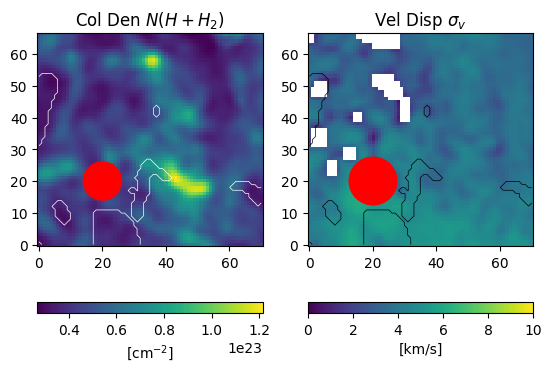

In [74]:
plt.figure(figsize=(10,5))
fig,(ax1,ax2) = plt.subplots(ncols=2,nrows=1)
g = ax1.imshow(col_den_map,origin='lower')#,vmin=0,vmax=1000)
ax1.contour(mask,[0.9],colors='white',linewidths=0.5)
circ = patches.Circle((20,20),0.5*col_den_beam_fwhm,color="red",alpha=1.0, zorder=5)
ax1.add_patch(circ)
plt.colorbar(g,ax=ax1,orientation='horizontal',label=r'[cm$^{-2}$]')
ax1.set_title(r'Col Den $N(H+H_{2})$')

g = ax2.imshow(vel_disp_map,origin='lower',vmin=0.,vmax=10.)
circ = patches.Circle((20,20),0.5*vel_disp_beam_fwhm,color="red",alpha=1.0, zorder=5)
ax2.add_patch(circ)
plt.colorbar(g,ax=ax2,orientation='horizontal', label='[km/s]')
ax2.contour(mask,[0.9],colors='k',linewidths=0.5)
ax2.set_title(r'Vel Disp $\sigma_{v}$')
bratio = r'$\langle B_{t}^{2}\rangle/\langle B_{0}^{2}\rangle$'

Motivated by the morphology of the 30Dor cloud, the analysis in Tram+23 uses two values for cloud's depth derived using the method described in Tutorial III. These two values are combined in one map (in case of only value, such can be defined as a single-value variable)

Text(0.5, 1.0, "Cloud's Depth Map")

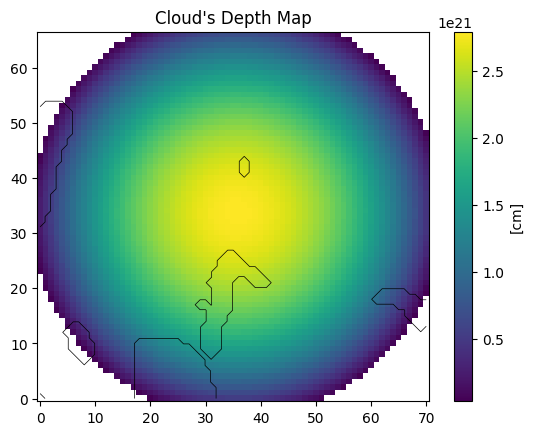

In [82]:
# cloud_depth = data['C_DEPTH'].data # in cm
# cloud_depth[cloud_depth == 0.0] = np.nan # replace zeros with NaNs to avoid divisions by zero.
g = plt.imshow(cloud_depth,origin='lower')
plt.colorbar(g,label='[cm]')
plt.contour(mask,[0.9],colors='k',linewidths=0.5)
plt.title("Cloud's Depth Map")

The final variable needed for the DCF calculation is the angular dispersion, $\sigma_{\phi}$. Such map is obtained from the results of the dispersion analysis such as demonstrated in Tutorial IV. We read in those results from a *pickle* file

In [26]:
import pickle
dfile = "/users/nsalem/polBpy tutorials/res3.pkl"
data = pickle.load(open(dfile,"rb"),encoding='iso-8859-1')
print(data.keys())

dict_keys(['a2_map', 'delta_map', 'ratio_map'])


First we define the $\langle B_{t}^{2}\rangle/\langle B_{0}^{2}\rangle$ map and its resolution. The resolution of this map is related to the kernel size, $w$, as $FWHM = 1.88\times w \times (pixel size)$, according to Guerra+21.

In [27]:
bt2b02_map = data['ratio_map']
bt2b02_map[bt2b02_map == 0.] = np.nan # replace zeros with NaNs to avoid divisions by zero.
bt2b02_beam_fwhm = 1.88*18.2*pixel_size # arcsec

$\sigma_{\phi}$ map is calculated as

In [28]:
ang_disp_map = np.sqrt(bt2b02_map)
print('Angular dispersion Beam FWHM = %s [arcsec]'%bt2b02_beam_fwhm)

Angular dispersion Beam FWHM = 155.6828 [arcsec]


Now, we visualize both maps,

Text(0.5, 1.0, '$\\sigma_{\\phi}$')

<Figure size 500x500 with 0 Axes>

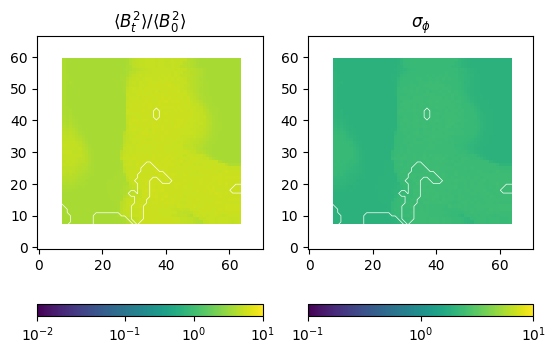

In [90]:
plt.figure(figsize=(5,5))
fig,(ax1,ax2) = plt.subplots(ncols=2,nrows=1)

g = ax1.imshow(bt2b02_map,origin='lower',norm=SymLogNorm(linthresh=0.03,vmin=0.01,vmax=10.0))
circ = patches.Circle((20,20),0.5*bt2b02_beam_fwhm,color="red",alpha=1.0, zorder=5)
#ax1.add_patch(circ)
ax1.contour(mask,[0.9],colors='white',linewidths=0.5)
plt.colorbar(g,ax=ax1,orientation='horizontal',label=r'')
bratio = r'$\langle B_{t}^{2}\rangle/\langle B_{0}^{2}\rangle$'
ax1.set_title(bratio)

g = ax2.imshow(ang_disp_map,origin='lower',norm=SymLogNorm(linthresh=0.03,vmin=0.1,vmax=10.0))
circ = patches.Circle((20,20),0.5*bt2b02_beam_fwhm,color="red",alpha=1.0, zorder=5)
#ax2.add_patch(circ)
ax2.contour(mask,[0.9],colors='white',linewidths=0.5)
plt.colorbar(g,ax=ax2,orientation='horizontal',label=r'')
ax2.set_title(r'$\sigma_{\phi}$')

Now, we are ready to combine the maps through the classical DCF approximation. We do so by calling the function *dcf_map*. This function requires all variables maps and their resolutions. It also accepts maps pf uncertainties associatted to the variables, if known. The type of DCF approximation can be specified using the keyword *dcftype* but the default value is the classical approximation. Using other DCF approximations (large-scale flow, shear flow) for $B_{\rm POS}$ maps has not been tested yet in the literature).

In [83]:
bpos_map, ubpos_map = DCF.dcf_map(col_den_map,vel_disp_map,ang_disp_map,pixel_size,m_cdepth=cloud_depth,
                                  res_den=col_den_beam_fwhm,res_vel=vel_disp_beam_fwhm,res_disp=bt2b02_beam_fwhm)

Maps have different resolutions. Applying sigma_convolve. Target resolution: 155.6828


And finally we can visualized the resulting $B_{\rm POS}$ map

Text(0.5, 1.0, 'POS Magnetic Field Strength')

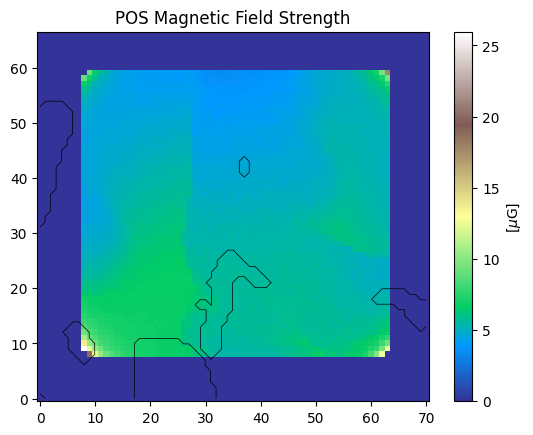

In [84]:
bpos_map[~np.isfinite(bpos_map)] = 0.0 # replace NaNs for zeros.
fig,ax = plt.subplots(ncols=1,nrows=1)
g = ax.imshow(bpos_map,origin='lower',cmap='terrain')
#circ = patches.Circle((20,20),0.5*bt2b02_beam_fwhm,color="red",alpha=1.0, zorder=5)
#ax.add_patch(circ)
plt.colorbar(g, label=r'[$\mu$G]')
ax.contour(mask,[0.9],colors='k',linewidths=0.5)
ax.set_title('POS Magnetic Field Strength')